# Information Retrieval Project
## Recommendation systems
### Elham Babaei


In [ ]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

The movielens dataset includes:
- 610 users
- 9742 movies


In [ ]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
print(movies.info())
print(ratings.info())
print(tags.info())

#get a list of the features within the dataset
print("Movie : ", movies.columns,end="\n\n")
print("Rating : ", ratings.columns,end="\n\n")
print("Tags : ", tags.columns,end="\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    36

In [ ]:
# Droping the timestamp column from ratings and tags file
ratings.drop(columns='timestamp',inplace=True)
tags.drop(columns='timestamp',inplace=True)

In [ ]:
print(movies.shape)
movies.head(5)

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print(ratings.shape)
ratings.head(5)

(100836, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
print(tags.shape)
tags.head(5)

(3683, 3)


,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


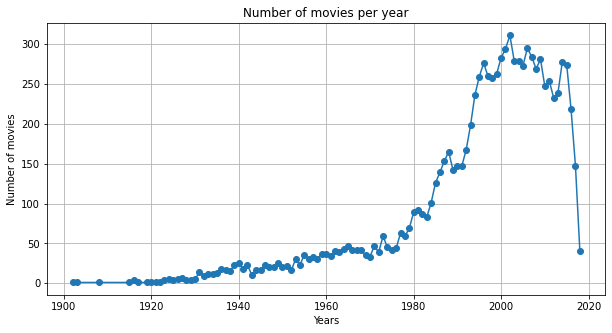

Max No.of Movies Relesed = 311
Year = 2002-01-01 00:00:00


count    106.000000
mean      91.764151
std      102.196594
min        1.000000
25%       16.000000
50%       39.500000
75%      151.500000
max      311.000000
Name: title, dtype: float64

In [ ]:
# extracting year from the the title of each movie
movies2= copy.deepcopy(movies)
movies2['movie_year'] = movies2['title']

movies2['movie_year'] = movies2['movie_year'].str.extract(r"\(([0-9]+)\)", expand=False)

# creating a new column with just the movie titles
movies2['title_only'] = movies2['title']
movies2['title_only'] = movies2['title_only'].str.extract('(.*?)\s*\(', expand=False)

movies2['movie_year'].fillna(0, inplace=True)

movies2.drop(movies2[movies2.movie_year == '0'].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == '6'].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == '06'].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == '69'].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == '500'].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == '-2147483648'].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == 0].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == 6].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == 69].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == 500].index, inplace=True)
movies2.drop(movies2[movies2.movie_year == -2147483648].index, inplace=True)

#convert the string values to numeric
movies2['movie_year'] = pd.to_datetime(movies2['movie_year'], format='%Y')

movie_year = pd.DataFrame(movies2['title_only'].groupby(movies2['movie_year']).count())
movie_year.reset_index(inplace=True)

X=movie_year['movie_year']
Y=movie_year['title_only']

plt.plot_date(X,Y,'o-')
plt.grid(True)
plt.rcParams["figure.figsize"] = (10,5)
plt.title('Number of movies per year')
plt.xlabel('Years')
plt.ylabel('Number of movies')
plt.show()

a=movies2.groupby('movie_year').title.count()
print('Max No.of Movies Relesed =',a.max())
for i in a.index:
    if a[i] == a.max():
        print('Year =',i)
a.describe()

In [ ]:
# looking at the frequency of each genre
movies3 = copy.deepcopy(movies)

genres=[]
for i in range(len(movies3.genres)):
    for x in movies3.genres[i].split('|'):
        if x not in genres:
            genres.append(x)  


for x in genres:
    movies3[x] = 0
for i in range(len(movies3.genres)):
    for x in movies3.genres[i].split('|'):
        movies3[x][i]=1      # if a movie includes a specific genre, we put 1 in the associated column of that genre

movies3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Adventure ---> 1263
Animation ---> 611
Children ---> 664
Comedy ---> 3756
Fantasy ---> 779
Romance ---> 1596
Drama ---> 4361
Action ---> 1828
Crime ---> 1199
Thriller ---> 1894
Horror ---> 978
Mystery ---> 573
Sci-Fi ---> 980
War ---> 382
Musical ---> 334
Documentary ---> 440
IMAX ---> 158
Western ---> 167
Film-Noir ---> 87
(no genres listed) ---> 34


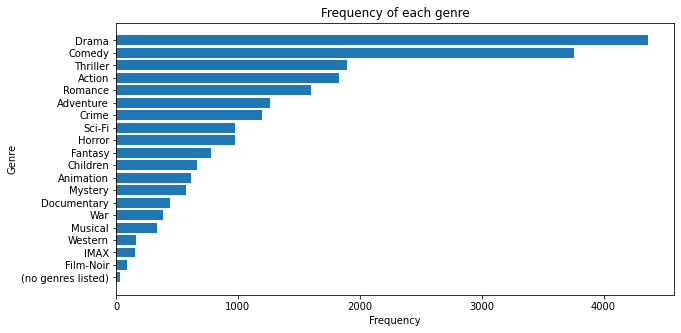

In [ ]:
# plot genre
x={}      
for i in movies3.columns[3:23]:
    x[i]=movies3[i].value_counts()[1]
    print(f'{i} ---> {x[i]}')

x= sorted(x.items(), key=lambda x: x[1])
x = pd.DataFrame(x)
myy = list(x[0])
myx= list(x[1])
plt.barh(y=myy, width=myx)
#plt.bar(height=x.values(),x=x.keys())
plt.rcParams["figure.figsize"] = (10,8)
plt.title('Frequency of each genre')
plt.xlabel('Frequency')
#plt.xticks(rotation=45, ha='right')
plt.ylabel('Genre')
plt.show()

In [ ]:
df = pd.merge(movies,ratings).drop(['genres'], axis=1)
df

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5
...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),184,4.0
100832,193583,No Game No Life: Zero (2017),184,3.5
100833,193585,Flint (2017),184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple (2018),184,3.5


In [ ]:
#creating the final dataset
df = df[['userId', 'movieId', 'rating']]
df= pd.DataFrame(df)
print(df)
print(df.shape)

        userId  movieId  rating
0            1        1     4.0
1            5        1     4.0
2            7        1     4.5
3           15        1     2.5
4           17        1     4.5
...        ...      ...     ...
100831     184   193581     4.0
100832     184   193583     3.5
100833     184   193585     3.5
100834     184   193587     3.5
100835     331   193609     4.0

[100836 rows x 3 columns]
(100836, 3)


,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


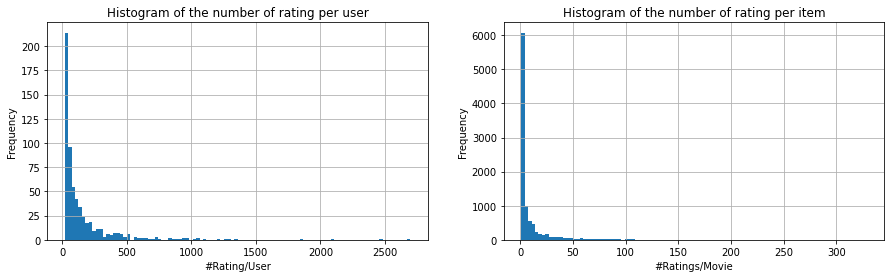

In [ ]:
# looking at the dataset
fig, ax = plt.subplots(1,2,figsize=(15,4))
df.groupby("userId").count()["movieId"].hist(bins=100,ax=ax[0])
_ = ax[0].set_title("Histogram of the number of rating per user")
_= ax[0].set_xlabel('#Rating/User')
_ = ax[0].set_ylabel('Frequency')

df.groupby("movieId").count()["userId"].hist(bins=100,ax=ax[1])
_ = ax[1].set_title("Histogram of the number of rating per item")
_= ax[1].set_xlabel('#Ratings/Movie')
_ = ax[1].set_ylabel('Frequency')

df.describe()

Each user has given at least 20 ratings.

In [ ]:
# the number of ratings given by each user
print(df.groupby("userId").count()["rating"].describe())

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64


In [ ]:
# creating the rating matrix
ratings_df = df.pivot_table(index=['userId'],columns=['movieId'],values='rating')
ratings_df.fillna(0, inplace=True)   # data frame
ratings = ratings_df.to_numpy()     # numpy ndarray

mat_size= np.prod(ratings.shape)    # 610*9724
n_nonzero_ratings = np.flatnonzero(ratings).shape[0]    
sparsity = (1- (n_nonzero_ratings / mat_size) ) *100
print (f'sparsity percentage of ratings matrix: {sparsity:.1f}%')     

print('ratings matrix dimensions:', ratings.shape)
print(ratings)

sparsity percentage of ratings matrix: 98.3%
ratings matrix dimensions: (610, 9724)
[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [ ]:
type(ratings)

numpy.ndarray

To split data into the train and test datasets, we just remove some available ratings(nonzero) from our ratings matrix and consider it as the test dataset.
Because the dimension of both train and test dataset should be the same and equal to the ratings matrix size to be able to use Matrix Factorization later on. 
So we cannot split the ratings matrix into two smaller matrices as train and test.

Given we already know each user has given more than 10 ratings, what we'll do is for every user, we remove 10 of the item ratings and assign them to the test set.

In [ ]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(np.flatnonzero(ratings[user]), size = 10, replace = False)
        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(ratings)
print(train.shape)
print(test.shape)

(610, 9724)
(610, 9724)


To define the embedding matrices we do not know:
- the number of latent factors (k)
- what the latent factors are

In [ ]:
class wighted_MF:
  def __init__(self, n_iterations, n_factors, w0):
    self.n_iterations= n_iterations
    self.n_factors = n_factors
    self.w0 = w0

  #fitting the model
  def fit(self, train, test):
    self.n_users, self.n_items = train.shape
    self.user_embeddings = np.random.normal(size=(self.n_users, self.n_factors))   # U
    self.item_embedding = np.random.normal(size=(self.n_items, self.n_factors))    # V

    self.test_mse_record = []      # to record MSE error
    self.train_mse_record = []
    for i in range(self.n_iterations):       #training the model
      self.user_embeddings = self._WALS(train, self.user_embeddings, self.item_embedding)  # solve for fixed V
      self.item_embedding = self._WALS(train.T, self.item_embedding, self.user_embeddings) # solve for fixed U
       
      predictions = self.predict()
      test_mse = self.compute_mse(test, predictions)
      train_mse = self.compute_mse(train, predictions)
      self.test_mse_record.append(test_mse)
      self.train_mse_record.append(train_mse)
      

    return self

  # this method solves C=UV for fixed u and vice versa by getting the derivatives
  def _WALS(self, ratings, solve_vecs, fixed_vecs):
    a = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.w0
    a_inv = np.linalg.inv(a)
    b = ratings.dot(fixed_vecs)
    solve_vecs = b.dot(a_inv)
    return solve_vecs
    
  # predicts the ratings    
  def predict(self):
    pred = self.user_embeddings.dot(self.item_embedding.T)    # U*Vt
    return pred

  @staticmethod
  def compute_mse(y_true, y_pred):
    mask = np.nonzero(y_true)     #ignore zero ratings
    mse = mean_squared_error(y_true[mask], y_pred[mask])
    return mse

In [ ]:
#visualize the training/testing loss
def plot_learning_curve(model):
    linewidth = 3
    plt.rcParams["figure.figsize"] = (10,5)
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.title('MSE error')
    plt.legend(loc = 'best')

The following plot shows that WALS converges fastly.

In [ ]:
import time
start_time = time.time()

mymodel = wighted_MF(n_iterations = 100, n_factors = 40, w0 = 0.1)
mymodel.fit(train, test)

print(f'Seconds: {time.time()-start_time}')

Seconds: 23.19768524169922


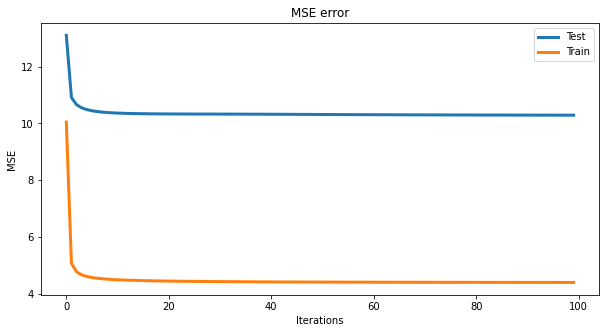

In [ ]:
plot_learning_curve(mymodel)

In [ ]:
print( 'Average test MSE: ', mean(mymodel.test_mse_record))
print( 'Average train MSE: ', mean(mymodel.train_mse_record))

Average test MSE:  10.360630606551672
Average train MSE:  4.500254856427464


In [ ]:
# final U and V
U = mymodel.user_embeddings
V = mymodel.item_embedding
C_approximated = pd.DataFrame (U.dot(V.T))

colnames = list(ratings_df.columns)
rownames = list(ratings_df.index)
C_approximated.columns = colnames
C_approximated.index = rownames

print('U shape: ', U.shape)  
print('V shape:' ,V.shape) 
print('C_approximated shape: ', C_approximated.shape)  
#print(C_approximated.describe() )
print('C_approximated: \n',C_approximated) 
print('C real(ratings matrix):\n',ratings)

U shape:  (610, 40)
V shape: (9724, 40)
C_approximated shape:  (610, 9724)
C_approximated: 
        1         2         3       ...  193585    193587    193609
1    3.497251  0.381825  1.353872  ...     0.0 -0.026071 -0.060732
2    0.240155 -0.002077 -0.041792  ...     0.0  0.008247  0.017447
3   -0.010514  0.002361  0.057208  ...     0.0 -0.000798 -0.001453
4    1.843769 -0.085551 -0.239604  ...     0.0 -0.005918 -0.006021
5    1.064515  0.841579  0.309624  ...     0.0 -0.001353  0.003277
..        ...       ...       ...  ...     ...       ...       ...
606  2.692108  0.023498  0.181179  ...     0.0 -0.039771 -0.057492
607  2.865503  1.563101  0.538289  ...     0.0 -0.011397 -0.040497
608  1.038914  2.422161  3.107254  ...     0.0 -0.014384  0.036209
609  0.559981  0.525596  0.137997  ...     0.0  0.001760  0.004321
610  5.110386  0.021788 -0.094111  ...     0.0 -0.015881  0.048842

[610 rows x 9724 columns]
C real(ratings matrix):
 [[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.

we use item to item collaborative filtering.

In [ ]:
# compute similarity between items based on cosine similarity
""" C_approximated.T transpose because we want item similarity"""
item_similarity = pd.DataFrame(cosine_similarity(C_approximated.T), index= ratings_df.columns, columns= ratings_df.columns)   
item_similarity = pd.DataFrame(item_similarity)
item_similarity

# alternative solution
#"""
#this is correct when we consider the assumption that the mean of each
#column is zero in the C_approximated matrix.
#"""
#C_approximated = pd.DataFrame(C_approximated)
#item_similarity = C_approximated.corr(method='pearson')
#item_similarity = pd.DataFrame(item_similarity)
#item_similarity


movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.722542,0.498184,0.288227,0.555568,0.590114,0.480009,0.297563,0.328417,0.640713,0.545120,0.382700,0.486847,0.321713,0.268077,0.473273,0.580904,0.295847,0.664071,0.349770,0.558942,0.389678,0.311269,0.474871,0.507087,0.284072,0.297857,0.309757,0.375034,0.123642,0.481311,0.725234,0.743850,0.560091,0.238631,0.666727,0.302774,0.348977,0.268927,0.233177,...,0.166279,0.109079,0.240644,0.047133,0.240644,0.240644,0.304612,0.176251,0.193272,-0.027254,-0.027254,0.204327,-0.003111,0.150518,0.240644,-0.003111,0.0,0.0,0.078156,-0.003111,0.127046,-0.027254,0.251350,0.0,0.130490,0.130490,0.130490,0.130490,0.130490,0.027856,0.027856,0.027856,0.027856,0.027856,0.027856,0.027856,0.027856,0.0,0.027856,0.149908
2,0.722542,1.000000,0.602541,0.466215,0.661088,0.474644,0.626206,0.430237,0.216988,0.726480,0.587199,0.368073,0.509094,0.226619,0.468248,0.454049,0.438867,0.340133,0.822267,0.329570,0.514574,0.567182,0.428371,0.530479,0.347009,0.387854,0.405748,0.198946,0.294058,0.015356,0.605771,0.685973,0.779676,0.452358,0.219176,0.635584,0.123710,0.348395,0.199114,0.252294,...,0.251138,0.183386,0.187761,0.181424,0.187761,0.187761,0.049240,0.337470,0.251888,0.035902,0.035902,0.245751,0.157402,0.112575,0.187761,0.157402,0.0,0.0,0.140890,0.157402,0.152118,0.035902,0.104969,0.0,-0.073800,-0.073800,-0.073800,-0.073800,-0.073800,0.108683,0.108683,0.108683,0.108683,0.108683,0.108683,0.108683,0.108683,0.0,0.108683,0.035206
3,0.498184,0.602541,1.000000,0.514972,0.737405,0.470003,0.678786,0.464228,0.471534,0.534882,0.565364,0.355025,0.388759,0.242824,0.522184,0.545440,0.426998,0.279906,0.655470,0.226895,0.561663,0.664358,0.325554,0.619280,0.379567,0.332062,0.533282,0.068634,0.215514,0.056116,0.640374,0.517455,0.563597,0.483636,0.216607,0.596073,0.179333,0.311173,0.318035,0.202541,...,0.051895,-0.016174,0.159385,0.099684,0.159385,0.159385,-0.047049,0.037868,0.249426,-0.079187,-0.079187,-0.045599,-0.001999,-0.105939,0.159385,-0.001999,0.0,0.0,-0.007766,-0.001999,-0.020841,-0.079187,-0.102755,0.0,-0.001746,-0.001746,-0.001746,-0.001746,-0.001746,-0.020702,-0.020702,-0.020702,-0.020702,-0.020702,-0.020702,-0.020702,-0.020702,0.0,-0.020702,-0.035121
4,0.288227,0.466215,0.514972,1.000000,0.687901,0.345505,0.757356,0.411968,0.555474,0.299871,0.555689,0.134991,0.302884,0.592891,0.494554,0.294469,0.621461,0.156106,0.350643,0.114856,0.544367,0.459653,0.286568,0.377703,0.580317,0.468582,0.543939,0.222853,0.153383,0.115453,0.615650,0.364010,0.501613,0.686933,-0.005404,0.510107,0.456552,0.447286,0.006939,0.113153,...,0.071480,0.008570,0.000083,0.062754,0.000083,0.000083,0.000747,0.080217,0.112533,0.027505,0.027505,-0.013004,-0.038709,0.038757,0.000083,-0.038709,0.0,0.0,0.100466,-0.038709,0.115117,0.027505,0.019895,0.0,0.045161,0.045161,0.045161,0.045161,0.045161,0.084082,0.084082,0.084082,0.084082,0.084082,0.084082,0.084082,0.084082,0.0,0.084082,-0.111401
5,0.555568,0.661088,0.737405,0.687901,1.000000,0.425396,0.752628,0.434034,0.437410,0.527359,0.646502,0.253464,0.449600,0.442284,0.470473,0.537607,0.557261,0.301288,0.638344,0.221457,0.602990,0.628116,0.416006,0.517511,0.485693,0.535657,0.643008,0.272083,0.238058,0.048553,0.777387,0.486769,0.626690,0.576254,0.287220,0.696812,0.313173,0.431901,0.121200,0.280456,...,0.034450,0.029007,0.122649,0.061574,0.122649,0.122649,0.027671,0.044439,0.163026,-0.078946,-0.078946,0.007094,-0.022944,0.158086,0.122649,-0.022944,0.0,0.0,0.101059,-0.022944,0.001006,-0.078946,0.115895,0.0,-0.030686,-0.030686,-0.030686,-0.030686,-0.030686,0.114082,0.11408

In [ ]:
def get_similar(itemID,rating):
    similar_ratings = item_similarity[itemID]*(rating-2.5)    # the average of rating is 2.5
    similar_ratings = similar_ratings.sort_values(ascending=False)
    return similar_ratings

In [ ]:
new_user = [(1,5),(3,5),(100,2.5),(23,1)]
similar_movies = pd.DataFrame()
for movie,rating in new_user:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
similar_movies.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.500000,1.806356,1.245460,0.720567,1.388921,1.475285,1.200024,0.743906,0.821041,1.601781,1.362800,0.956749,1.217118,0.804284,0.670192,1.183182,1.452259,0.739617,1.660178,0.874425,1.397356,0.974196,0.778172,1.187177,1.267716,0.710179,0.744643,0.774392,0.937584,0.309105,1.203278,1.813085,1.859624,1.400227,0.596577,1.666817,0.756934,0.872442,0.672318,0.582943,...,0.415697,0.272698,0.601609,0.117832,0.601609,0.601609,0.761530,0.440628,0.483180,-0.068135,-0.068135,0.510818,-0.007779,0.376295,0.601609,-0.007779,0.0,0.0,0.195391,-0.007779,0.317615,-0.068135,0.628374,0.0,0.326226,0.326226,0.326226,0.326226,0.326226,0.069640,0.069640,0.069640,0.069640,0.069640,0.069640,0.069640,0.069640,0.0,0.069640,0.374771
1,1.245460,1.506352,2.500000,1.287429,1.843511,1.175008,1.696964,1.160570,1.178835,1.337205,1.413411,0.887562,0.971899,0.607059,1.305460,1.363599,1.067495,0.699764,1.638675,0.567237,1.404156,1.660894,0.813885,1.548201,0.948919,0.830156,1.333205,0.171584,0.538784,0.140291,1.600936,1.293637,1.408991,1.209090,0.541517,1.490182,0.448332,0.777933,0.795089,0.506352,...,0.129737,-0.040434,0.398463,0.249210,0.398463,0.398463,-0.117622,0.094670,0.623564,-0.197968,-0.197968,-0.113998,-0.004997,-0.264848,0.398463,-0.004997,0.0,0.0,-0.019415,-0.004997,-0.052103,-0.197968,-0.256887,0.0,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.051756,-0.051756,-0.051756,-0.051756,-0.051756,-0.051756,-0.051756,-0.051756,0.0,-0.051756,-0.087801
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.0,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.000000
3,-0.466903,-0.642556,-0.488331,-0.429851,-0.624010,-0.768985,-0.535884,-0.980385,-0.265131,-0.844922,-0.574875,-0.497705,-0.290556,-0.603047,-0.609026,-0.797235,-0.479742,-0.836221,-0.639557,-0.576569,-0.715007,-0.960374,-1.500000,-0.638523,-0.545184,-0.911619,-0.554628,-0.050544,-0.628789,-0.042738,-0.770968,-0.663368,-0.512163,-0.520786,-0.019252,-0.277748,-0.103556,-0.788941,-0.421156,-0.287329,...,-0.079118,0.010618,0.076192,0.013307,0.076192,0.076192,0.013925,-0.002611,-0.336953,0.094289,0.094289,0.020162,-0.029766,0.042688,0.076192,-0.029766,-0.0,-0.0,0.177833,-0.029766,0.070359,0.094289,0.009700,-0.0,-0.122121,-0.122121,-0.122121,-0.122121,-0.122121,0.150847,0.150847,0.150847,0.150847,0.150847,0.150847,0.150847,0.150847,-0.0,0.150847,-0.020482


The sum of columns in the above matrix is the ranking of each movie.

In [ ]:
similar_movies.sum().sort_values(ascending=False).head(20)

1       3.278556
3       3.257129
2054    3.191534
788     3.045911
586     3.034914
1073    2.979349
780     2.887071
2987    2.881919
39      2.879251
2804    2.872025
2406    2.871923
500     2.869991
2797    2.864688
480     2.860697
3421    2.853950
2174    2.845799
104     2.838188
736     2.826242
588     2.813096
2918    2.806585
dtype: float64

In [ ]:
movies[(movies['movieId']==2054) | (movies['movieId']==788) | (movies['movieId']==3)| (movies['movieId']==1)
| (movies['movieId']==23) | (movies['movieId']==100) ]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
22,23,Assassins (1995),Action|Crime|Thriller
88,100,City Hall (1996),Drama|Thriller
622,788,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi
1522,2054,"Honey, I Shrunk the Kids (1989)",Adventure|Children|Comedy|Fantasy|Sci-Fi
